In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
import scipy

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
from typing import Optional

import pandas as pd
from IPython.display import Image
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from statsforecast.arima import ARIMASummary, ndiffs, nsdiffs
from statsforecast.models import ARIMA, AutoARIMA, AutoETS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from utilsforecast.losses import mae, rmse, smape

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image, Markdown, display
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import fourier, pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse
from utilsforecast.processing import make_future_dataframe


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import SplineTransformer
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

In [6]:
df = pd.read_csv("../data/aus_accomodation.csv", parse_dates=["ds"])
df["y"] = 100 * df["Takings"] / df["CPI"]

In [ ]:
states = df.unique_id.unique()

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, state in zip(axes.flatten(), states):
    sns.lineplot(df[df["unique_id"] == state], x="ds", y="y", ax=ax)
    ax.set_title(f"CPI Adj Quaterly Taking in {state}")
plt.tight_layout()

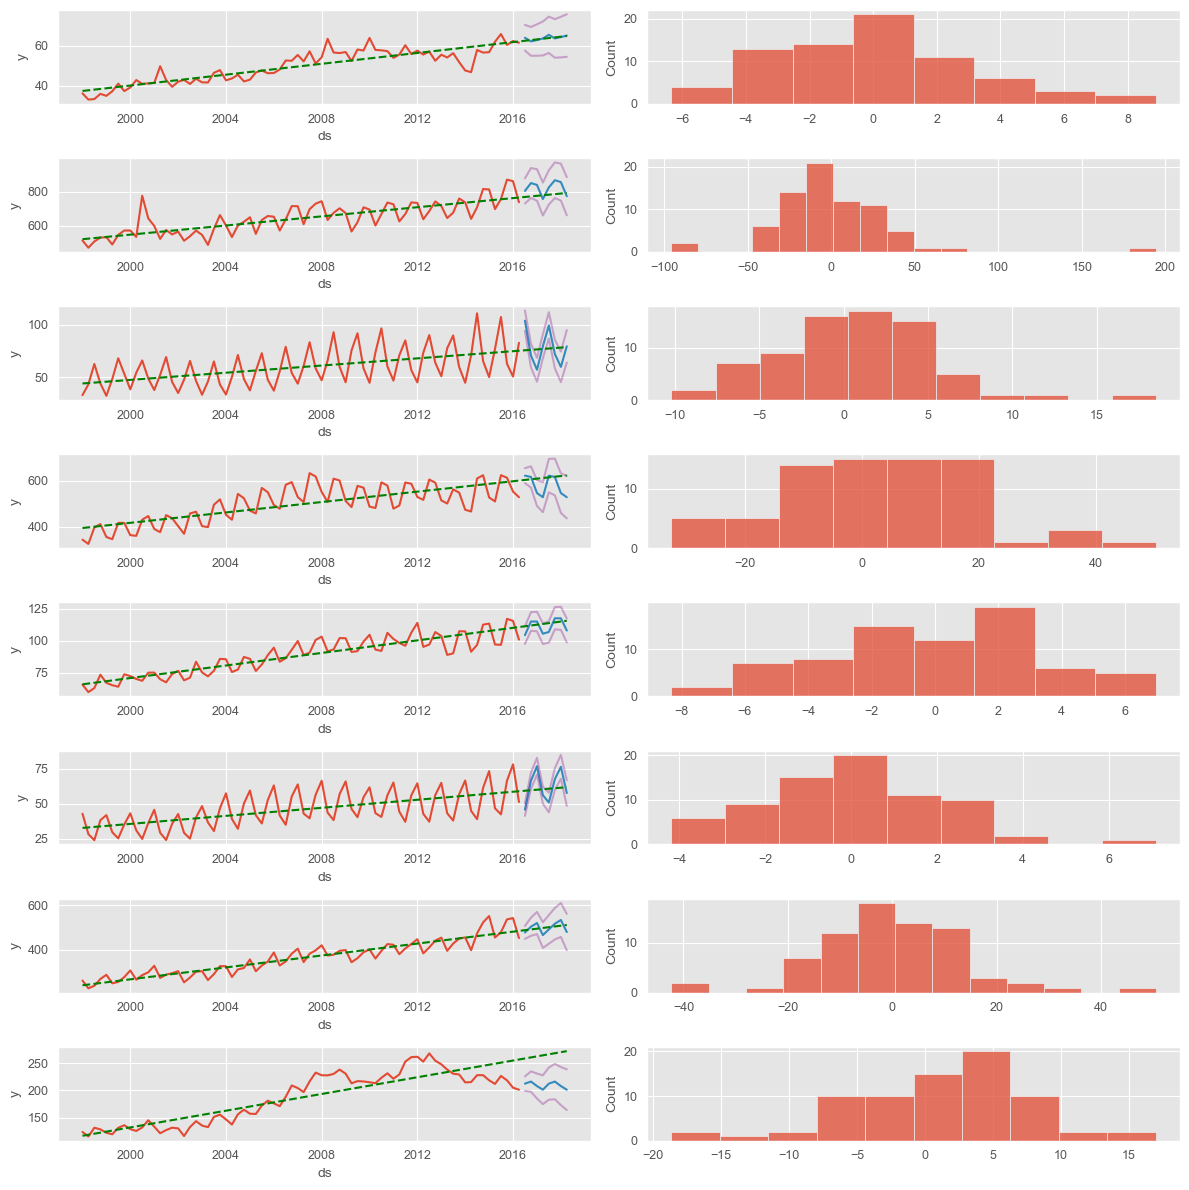

In [133]:
states = df.unique_id.unique()

fig, axes = plt.subplots(8, 2, figsize=(12, 12))
for ax, state in zip(axes, states):
    # Setup the dataframe for the state
    state_df = df[df.unique_id == state].reset_index(drop=True)
    state_df["Quarters"] = state_df.ds.dt.quarter
    state_df = pd.get_dummies(state_df, columns=["Quarters"], drop_first=True)

    # Setup the model to be used non seasonal ARIMA with quaterly seasons
    sf = StatsForecast(
        models=[AutoARIMA(season_length=4, seasonal=False)],
        freq="QS",
    )

    # Generate the future dates/quarter to use for prediction
    future_predictors = make_future_dataframe(
        state_df["unique_id"].unique(),
        pd.to_datetime([state_df["ds"].max()]),
        freq="QS",
        h=8,
    )
    future_predictors["Quarters"] = future_predictors.ds.dt.quarter
    future_predictors = pd.get_dummies(
        future_predictors, columns=["Quarters"], drop_first=True
    )

    sf.fit(
        df=state_df[["unique_id", "ds", "y", "Quarters_2", "Quarters_3", "Quarters_4"]],
        target_col="y",
    )

    # Forecast the next 2 years
    fc = sf.forecast(
        df=state_df[["unique_id", "ds", "y", "Quarters_2", "Quarters_3", "Quarters_4"]],
        X_df=future_predictors,
        h=8,
        target_col="y",
        fitted=True,
        level=[80, 95],
    )

    # Plot the true data and forecasting
    sns.lineplot(state_df, x="ds", y="y", ax=ax[0])
    sns.lineplot(fc.drop("unique_id", axis=1), x="ds", y="AutoARIMA", ax=ax[0])
    sns.lineplot(
        fc.drop("unique_id", axis=1),
        x="ds",
        y="AutoARIMA-lo-95",
        ax=ax[0],
        color="purple",
        alpha=0.3,
    )
    sns.lineplot(
        fc.drop("unique_id", axis=1),
        x="ds",
        y="AutoARIMA-hi-95",
        ax=ax[0],
        color="purple",
        alpha=0.3,
    )

    # Fit a simple linear trend
    t = state_df.index.values
    t = np.append(t, t[-1] + range(1, 9)).reshape(-1, 1)
    lintrend = LinearRegression().fit(t[:-8], state_df.y)

    # Plot the fitted trend
    sns.lineplot(
        x=pd.concat((state_df.ds, future_predictors.ds)),
        y=lintrend.predict(t),
        ax=ax[0],
        color="green",
        linestyle="--",
    )

    innov_residuals = sf.fitted_[0, 0].model_["residuals"]
    sns.histplot(innov_residuals, ax=ax[1])

plt.tight_layout()